<a href="https://colab.research.google.com/github/llawlaw23/Recommendation-System/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
import gc
import re

In [ ]:
props1 = pd.read_csv("item_properties_part1.1.csv")
props2 = pd.read_csv("item_properties_part2.csv")
props = pd.concat([props1, props2])

Mapping itemid to categoryid from Properties Dataset

In our dataset, the category of each item is stored within the properties table, specifically in rows where the property column has the value "categoryid". To extract a clean mapping of itemid → categoryid, we perform the following steps:

Filter the dataset to keep only rows where property == "categoryid".

Rename the value column to categoryid for clarity.

Convert the category IDs to integers to facilitate merging with other tables.


In [ ]:
df_items = props[props["property"] == "categoryid"][["itemid", "value"]]

In [ ]:
df_items = df_items.rename(columns={"value": "categoryid"})

In [ ]:
df_items["categoryid"] = df_items["categoryid"].astype("Int64")

In [ ]:
# saved the clean csv as an new file in the cleaned folder and delete the previous one
df_items.to_csv("df_item.csv", index = False)
del df_items; gc.collect()

In [ ]:
props.shape

(20275902, 4)

In [ ]:
props.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [ ]:
events = pd.read_csv("events.csv")
cats = pd.read_csv("category_tree.csv")

### Data Understanding & Preprocessing

#### 1. Data Overview
- Brief description of the dataset ( size, number of features, number of columns and rows, and observations)
- Types of variables (numerical, categorical, datetime, etc.)
- Initial observations about the data (e.g., imbalance, missing data, outliers)

#### 2. Data Quality Checks
- Check for missing values and filling or dropping them.
- dropping columns.
- checking for outliers.

In [ ]:
events["timestamp"] = pd.to_datetime(events["timestamp"], unit = "ms")

In [ ]:
events.shape

(2756101, 5)

In [ ]:
events.isnull().sum()

,0
timestamp,0
visitorid,0
event,0
itemid,0
transactionid,2733644


In [ ]:
events = events.drop(columns = ["transactionid"])

In [ ]:
events.head()

,timestamp,visitorid,event,itemid
0,2015-06-02 05:02:12.117,257597,view,355908
1,2015-06-02 05:50:14.164,992329,view,248676
2,2015-06-02 05:13:19.827,111016,view,318965
3,2015-06-02 05:12:35.914,483717,view,253185
4,2015-06-02 05:02:17.106,951259,view,367447


In [ ]:
# map view = 1 add to chart = 3 and purchase  = 5, replacing it in the old column. dataype to int
event_weights = {"view": 1, "addtocart": 2, "transaction": 3}
events["event"] = events["event"].map(event_weights)

In [ ]:
# change datatype of event to int
events["event"] = events["event"].fillna(0).astype(int)

In [ ]:
events.head(20)

,timestamp,visitorid,event,itemid
0,2015-06-02 05:02:12.117,257597,1,355908
1,2015-06-02 05:50:14.164,992329,1,248676
2,2015-06-02 05:13:19.827,111016,1,318965
3,2015-06-02 05:12:35.914,483717,1,253185
4,2015-06-02 05:02:17.106,951259,1,367447
5,2015-06-02 05:48:06.234,972639,1,22556
6,2015-06-02 05:12:03.240,810725,1,443030
7,2015-06-02 05:34:51.897,794181,1,439202
8,2015-06-02 04:54:59.221,824915,1,428805
9,2015-06-02 05:00:04.592,339335,1,82389


In [ ]:
# min in visitorid
events["visitorid"].min()

0

checking for outliers and clearing them

In [ ]:
visitor_event = events.groupby("visitorid")["event"].count()

In [ ]:
# print in descending order
visitor_event = visitor_event.sort_values(ascending = False)

In [ ]:
visitor_event.head(20)

,event
visitorid,
1150086,7757
530559,4328
152963,3024
895999,2474
163561,2410
371606,2345
286616,2252
684514,2246
892013,2024


In [ ]:
Q1 = visitor_event.quantile(0.25)
Q3 = visitor_event.quantile(0.75)
IQR = Q3 - Q1

In [ ]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
upper_bound

np.float64(3.5)

In [ ]:
lower_bound

np.float64(-0.5)

In [ ]:
outlier_visitor_ids = visitor_event[(visitor_event < lower_bound) | (visitor_event > upper_bound)].index

In [ ]:
is_outlier = events["visitorid"].isin(outlier_visitor_ids)

In [ ]:
print (is_outlier)

0          False
1           True
2          False
3          False
4          False
           ...  
2756096    False
2756097    False
2756098    False
2756099    False
2756100    False
Name: visitorid, Length: 2756101, dtype: bool


In [ ]:
events_F = events[~is_outlier]

In [ ]:
events_F.head()

,timestamp,visitorid,event,itemid
0,2015-06-02 05:02:12.117,257597,1,355908
2,2015-06-02 05:13:19.827,111016,1,318965
3,2015-06-02 05:12:35.914,483717,1,253185
4,2015-06-02 05:02:17.106,951259,1,367447
5,2015-06-02 05:48:06.234,972639,1,22556


In [ ]:
events_F.shape

(1652380, 4)

In [ ]:
props.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [ ]:
itemid_value = props.groupby("itemid")["value"].count()

In [ ]:
Q1 = itemid_value.quantile(0.25)
Q3 = itemid_value.quantile(0.75)
IQR = Q3 - Q1

In [ ]:
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [ ]:
outlier_itemid_value = itemid_value[(itemid_value < lower_bound) | (itemid_value > upper_bound)].index

In [ ]:
is_outlier = props["itemid"].isin(outlier_itemid_value)

In [ ]:
props = props[~is_outlier]

In [ ]:
props.shape

(17520979, 4)

In [ ]:
# clean the value column and keep values with n attached to them and add them if they are multiple
def sum_n_values(text):
    nums = re.findall(r"n([\d\.]+)", str(text))
    nums = [float(x) for x in nums]
    return sum(nums) if nums else None

props["value_n"] = props["value"].apply(sum_n_values)

In [ ]:
props = props.drop(columns = ["value"])

In [ ]:
props.head()

,timestamp,itemid,property,value_n
0,1435460400000,460429,categoryid,NaN
1,1441508400000,206783,888,277.2
2,1439089200000,395014,400,1272.0
3,1431226800000,59481,790,15360.0
4,1431831600000,156781,917,NaN


In [ ]:
# drop null values in value_n column
props = props.dropna(subset = ["value_n"])

In [ ]:
props["timestamp"] = pd.to_datetime(props["timestamp"], unit = "ms")

In [ ]:
props.shape

(4300636, 4)

In [ ]:
cats.isnull().sum()

,0
categoryid,0
parentid,25


In [ ]:
cats = cats.dropna()

In [ ]:
# saved the clean csv as an new file in the cleaned folder and delete the previous one
props.to_csv("props_cleaned.csv", index = False)
del props; gc.collect()

In [ ]:
# saved the clean csv as an new file in the cleaned folder and delete the previous one
events_F.to_csv("events_cleaned.csv", index = False)
del events_F; gc.collect()

In [ ]:
# saved the clean csv as an new file in the cleaned folder and delete the previous one
cats.to_csv("cats_cleaned.csv", index = False)
del cats; gc.collect()

In [1]:
import pandas as pd

In [2]:
# Loading cleaned csv files
props_cleaned = pd.read_csv("props_cleaned.csv")

events_cleaned = pd.read_csv("events_cleaned.csv")

cats_cleaned = pd.read_csv("cats_cleaned.csv")

df_items = pd.read_csv("df_item.csv")

In [22]:
df_items.head()

,itemid,categoryid
0,460429,1338
1,281245,1277
2,35575,1059
3,8313,1147
4,55102,47


In [38]:
events_cleaned.head()

,timestamp,visitorid,event,itemid
0,2015-06-02 05:02:12.117,257597,1,355908
1,2015-06-02 05:13:19.827,111016,1,318965
2,2015-06-02 05:12:35.914,483717,1,253185
3,2015-06-02 05:02:17.106,951259,1,367447
4,2015-06-02 05:48:06.234,972639,1,22556


In [3]:
df_items = df_items.drop_duplicates(subset = "itemid").reset_index(drop = True)

In [4]:
from scipy.sparse import csr_matrix
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix
import numpy as np

In [5]:
visitor_ids = events_cleaned["visitorid"].unique()
item_ids = events_cleaned["itemid"].unique()

In [6]:
visitor_map = {v: i for i, v in enumerate(visitor_ids)}
item_map = {i: j for j, i in enumerate(item_ids)}

In [7]:
events_cleaned["visitor_idx"] = events_cleaned["visitorid"].map(visitor_map)
events_cleaned["item_idx"] = events_cleaned["itemid"].map(item_map)

In [8]:
user_computed_agg = events_cleaned.groupby(['visitor_idx', 'item_idx'])['event'].sum().reset_index()

In [9]:
rows = user_computed_agg['visitor_idx'].values
cols = user_computed_agg['item_idx'].values
data = user_computed_agg['event'].values

user_item_matrix = csr_matrix((data, (rows, cols)), shape=(len(visitor_map), len(item_map)))
ui_matrix = user_item_matrix

Merging user_item_matrix with df dataset 

In [10]:
idx2visitor = {i: v for v, i in visitor_map.items()}
idx2item = {i: v for v, i in item_map.items()}

In [11]:
coo = user_item_matrix.tocoo()

In [12]:
user_item_long = pd.DataFrame({
    "visitorid": [idx2visitor[i] for i in coo.row],
    "itemid": [idx2item[j] for j in coo.col],
    "event": coo.data
})

In [13]:
merged = user_item_long.merge(df_items, on = "itemid", how = "left")

In [14]:
print(merged.head())

   visitorid  itemid  event  categoryid
0     257597  355908      1      1173.0
1     257597  302696      1      1173.0
2     111016  318965      2         NaN
3     483717  253185      2       914.0
4     483717  353936      1       914.0


In [17]:
merged.isnull().sum()

visitorid     0
itemid        0
event         0
categoryid    0
dtype: int64

In [18]:
# drop null values
merged = merged.dropna()

In [19]:
merged.shape

(1304805, 4)

In [24]:
# saved the clean csv as an new file in the cleaned folder and delete the previous one
merged.to_csv("merged.csv", index = False)
del merged; gc.collect()

205

In [25]:
merged = pd.read_csv("merged.csv")

In [26]:
# Compute correlation matrix
corr_matrix = merged.corr()

In [27]:
# define plt
import matplotlib.pyplot as plt
import seaborn as sns

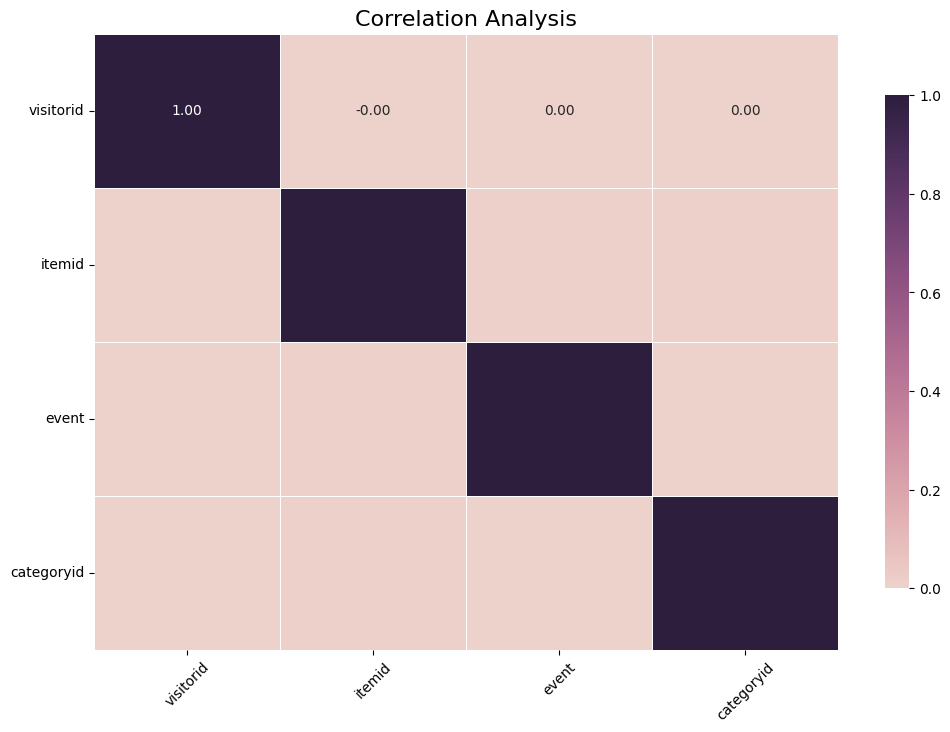

In [36]:
# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix, 
    annot = True, 
    fmt = ".2f", 
    cmap = sns.cubehelix_palette(as_cmap=True),
    linewidths = 0.5,
    cbar_kws= {"shrink": 0.8}
)

plt.title("Correlation Analysis", fontsize=16)
plt.xticks(rotation = 45)
plt.yticks(rotation = 0)
plt.show()

model Train / Test split + model training

In [86]:
import implicit
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split

In [94]:
als_model = implicit.als.AlternatingLeastSquares(factors = 32, iterations = 10, regularization = 0.1)
als_model.fit(user_item_matrix.T)

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning:

Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.06300830841064453 seconds



  0%|          | 0/10 [00:00<?, ?it/s]

In [96]:
# Recommend for first user
user_idx = 0
recommendations = als_model.recommend(user_idx, user_item_matrix[user_idx], N = 5)

In [97]:
print(recommendations)

(array([ 961556,  102313, 1055519,  571993,  538477], dtype=int32), array([3.5918900e-05, 3.2766675e-05, 3.2766671e-05, 3.2766671e-05,
       2.8993971e-05], dtype=float32))


In [99]:
# Split users or interactions for evaluation
train_df, test_df = train_test_split(events_cleaned, test_size = 0.2, random_state = 42)

In [100]:
# Map visitorid and itemid to indices (reuse your previous mapping)
train_df["visitor_idx"] = train_df["visitorid"].map(visitor_map)
train_df["item_idx"] = train_df["itemid"].map(item_map)
test_df["visitor_idx"] = test_df["visitorid"].map(visitor_map)
test_df["item_idx"] = test_df["itemid"].map(item_map)

In [102]:
from scipy.sparse import csr_matrix

# Train user-item matrix
train_ui = csr_matrix(
    (train_df["event"], (train_df["visitor_idx"], train_df["item_idx"])),
    shape = (len(visitor_ids), len(item_ids))
)

# Test user-item matrix (for evaluation)
test_ui = csr_matrix(
    (test_df["event"], (test_df["visitor_idx"], test_df["item_idx"])),
    shape = (len(visitor_ids), len(item_ids))
)


In [103]:
als_model = implicit.als.AlternatingLeastSquares(factors = 32, iterations = 10, regularization = 0.1)
als_model.fit(train_ui.T)

/usr/local/lib/python3.11/dist-packages/implicit/utils.py:164: ParameterWarning:

Method expects CSR input, and was passed csc_matrix instead. Converting to CSR took 0.06854414939880371 seconds



  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
def precision_recall_at_k(model, train_ui, test_ui, K = 5):
    import numpy as np
    precisions = []
    recalls = []

    num_users = train_ui.shape[0]

    for user_idx in range(num_users):
        # Skip users with no test interactions
        test_items = test_ui[user_idx].nonzero()[1]
        if len(test_items) == 0:
            continue

        # Recommend top K items for this user
        recommended = model.recommend(user_idx, train_ui[user_idx], N = K)

        # Check type of recommended
        # For newer implicit versions: recommended is a tuple (item_indices, scores)
        if isinstance(recommended, tuple):
            recommended_items = recommended[0]
        else:
            recommended_items = [i for i, score in recommended]

        # Precision@K
        hits = len(set(recommended_items) & set(test_items))
        precisions.append(hits / K)

        # Recall@K
        recalls.append(hits / len(test_items))

    return np.mean(precisions), np.mean(recalls)

# Evaluate
precision, recall = precision_recall_at_k(als_model, train_ui, test_ui, K = 5)
print(f"Precision@5: {precision:.3f}, Recall@5: {recall:.3f}")

### Data Visualization and Analysing Business Question

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

Q1
- How many unique visitors in a month?

In [81]:
events_cleaned["timestamp"] = pd.to_datetime(events_cleaned["timestamp"])

In [ ]:
events_cleaned.head()

,timestamp,visitorid,event,itemid
0,2015-06-02 05:02:12.117,257597,1,355908
1,2015-06-02 05:13:19.827,111016,1,318965
2,2015-06-02 05:12:35.914,483717,1,253185
3,2015-06-02 05:02:17.106,951259,1,367447
4,2015-06-02 05:48:06.234,972639,1,22556


In [82]:
events_cleaned["year_month"] = events_cleaned["timestamp"].dt.to_period("M")

In [83]:
monthly_visitors = events_cleaned.groupby("year_month")["visitorid"].nunique().reset_index()

In [84]:

print(monthly_visitors.head(10))

  year_month  visitorid
0    2015-05     274302
1    2015-06     276649
2    2015-07     337179
3    2015-08     279387
4    2015-09     155952


In [86]:
monthly_visitors["year_month"] = monthly_visitors["year_month"].astype(str)

In [87]:
color_map = {
    "2015-05": "#F564A9",
    "Jun 2015": "#98A1BC",
    "Jul 2015": "#DED3C4",
    "Aug 2015": "#264653",
    "Sep 2015": "#670D2F"
}

fig = px.bar(
    monthly_visitors,
    x = "year_month",
    y = "visitorid",
    color_discrete_map = color_map,
    title = "Unique Visitors per Month",
    labels = {"year_month": "Month", "visitorid": "Unique Visitors"},
    text = "visitorid"
)
fig.update_layout(
    legend_title_text = "Month",
    xaxis_title = "Month",
    yaxis = dict(
        showticklabels = False
    )
)

fig.show()

Q2
- What patterns exist in user-item interactions over time?

In [113]:
interactions_by_event = events_cleaned.groupby([events_cleaned['timestamp'].dt.date, 'event']).size().reset_index(name = 'count')

In [114]:

fig = px.line(interactions_by_event, x='timestamp', y='count', color='event',
              title='Interactions Over Time by Event Type',
              markers=True,
              color_discrete_sequence=px.colors.qualitative.Set2)

fig.update_layout(
    legend_title_text = "Month",
    xaxis_title = "Month",
    yaxis = dict(
        showticklabels = False
    )
)

fig.show()


Q3
- Most frequently interacted items?

In [74]:
top_items = events_cleaned['itemid'].value_counts().head(5).reset_index()
top_items.columns = ['itemid', 'event']

In [77]:

fig = px.bar(top_items, x = 'itemid', y ='event',
             title = 'Top 5 Most Interacted Items',
             color = 'event',
             color_continuous_scale = 'Viridis')

fig.update_layout(
    legend_title_text = "itemid",
    xaxis_title = "itemid",
    yaxis = dict(
        showticklabels = False
    )
)
fig.show()

Q4
- Top ten properties?

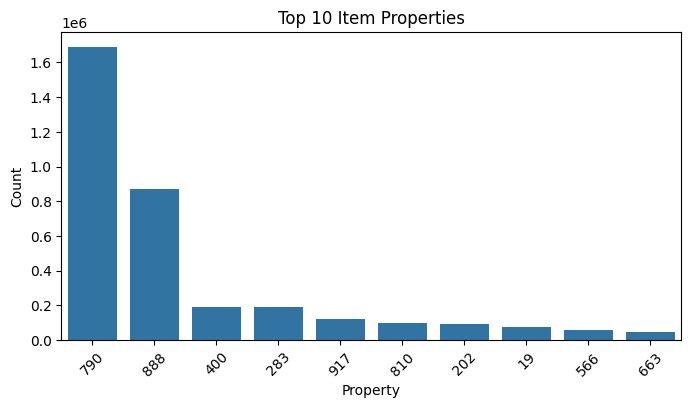

In [37]:
top_props = props_cleaned["property"].value_counts().head(10)

plt.figure(figsize = (8, 4))
sns.barplot(x = top_props.index, y = top_props.values, order = top_props.index)
plt.xticks(rotation = 45)
plt.title("Top 10 Item Properties")
plt.xlabel("Property")
plt.ylabel("Count")
plt.show()

Q5
- Top categories by total interactions?

In [67]:
category_counts = merged.groupby("categoryid")["itemid"].count().reset_index()
category_counts.columns = ["categoryid", "total_interactions"]

In [70]:
category_counts = category_counts.sort_values("total_interactions", ascending = False).head(5)
category_counts["categoryid"] = pd.Categorical(category_counts["categoryid"], categories = category_counts["categoryid"], ordered = True)

In [78]:
fig = px.bar(category_counts,
             x = "categoryid",
             y = "total_interactions",
             title = "Top 5 Categories by Total Interactions",
             labels = {"categoryid": "Category ID", "total_interactions": "Total Interactions"},
             color = "total_interactions")

fig.update_layout(legend_title_text = "Month",
                  xaxis_title = "Month",
                  yaxis = dict(
                      showticklabels = False
                      )
)
fig.show()

Q6
- What are the most frequently interacted items across all visitors?

In [104]:
item_counts = events_cleaned["itemid"].value_counts().reset_index()
item_counts.columns = ["itemid", "count"]

In [108]:
fig = px.bar(item_counts.head(3), x = "itemid", y = "count",
             title = "Most Popular Items",
             labels = {"count":"Number of Interactions", "itemid":"Item ID"})
fig.update_layout(
    legend_title_text = "itemid",
    xaxis_title = "itemid",
    yaxis = dict(
        showticklabels = False
    )
)
fig.show()

Q7
- How do the types of events vary across items and visitors?

In [53]:
event_counts = events_cleaned["event"].value_counts().reset_index()
event_counts.columns = ["event", "count"]

In [55]:
color_map = {
    1: "#F564A9",
    3: "#98A1BC",
    5: "#DED3C4",
}

fig = px.pie(event_counts, names = "event", values = "count",
             title = "Distribution of Event Types",
             color_discrete_map = color_map,)

fig.update_layout(
    legend_title_text = "event",
    xaxis_title = "event",
    yaxis = dict(
        showticklabels = False
    )
)
fig.show()